In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Question 1

In [2]:
df = yf.download("TCS.NS", start="2023-01-01", end="2023-12-31", interval="1d")


if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df


/tmp/ipython-input-742611051.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TCS.NS", start="2023-01-01", end="2023-12-31", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2023-01-02,2986.109375,2991.053626,2962.075472,2985.697410,709547
2023-01-03,3031.796143,3039.715795,2971.322234,2977.456555,1245178
2023-01-04,3034.817627,3046.445635,3008.769502,3027.538834,1231668
2023-01-05,3031.567139,3055.555212,3004.877935,3049.054526,1826057
2023-01-06,2940.421875,3022.823819,2929.846914,3021.404630,2488376
...,...,...,...,...,...
2023-12-22,3626.118896,3646.933000,3567.327220,3603.360828,2413058
2023-12-26,3599.141113,3635.601389,3594.020409,3622.183704,1285231
2023-12-27,3613.981445,3620.619216,3573.016966,3602.412806,1293976


In [3]:
def compute_rsi(df, period=14):
    delta = df["Close"].diff()

    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    return df



def compute_bollinger_bands(df, window=20, num_std=2):
    middle_band = df["Close"].rolling(window).mean()
    std_dev = df["Close"].rolling(window).std()

    df["BB_Middle"] = middle_band
    df["BB_Upper"] = middle_band + num_std * std_dev
    df["BB_Lower"] = middle_band - num_std * std_dev

    return df




df = compute_rsi(df)
print(df[["Close", "RSI"]].tail())

df = compute_bollinger_bands(df)
print(df[["Close", "BB_Middle", "BB_Upper", "BB_Lower"]].tail())

Price             Close        RSI
Date                              
2023-12-22  3626.118896  68.619616
2023-12-26  3599.141113  64.933204
2023-12-27  3613.981445  66.014806
2023-12-28  3603.266113  64.468604
2023-12-29  3597.102295  63.546572
Price             Close    BB_Middle     BB_Upper     BB_Lower
Date                                                          
2023-12-22  3626.118896  3453.240723  3712.510653  3193.970793
2023-12-26  3599.141113  3469.287512  3722.601880  3215.973144
2023-12-27  3613.981445  3485.457593  3731.935636  3238.979550
2023-12-28  3603.266113  3499.024707  3739.722889  3258.326525
2023-12-29  3597.102295  3513.523474  3740.069322  3286.977626


In [4]:
def compute_macd(df, fast=12, slow=26, signal=9):
    ema_fast = df["Close"].ewm(span=fast, adjust=False).mean()
    ema_slow = df["Close"].ewm(span=slow, adjust=False).mean()

    df["MACD"] = ema_fast - ema_slow
    df["MACD_Signal"] = df["MACD"].ewm(span=signal, adjust=False).mean()
    df["MACD_Hist"] = df["MACD"] - df["MACD_Signal"]

    return df


def compute_adx(df, period=14):
    high = df["High"]
    low = df["Low"]
    close = df["Close"]

    prev_close = close.shift(1)
    prev_high = high.shift(1)
    prev_low = low.shift(1)

    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    plus_dm = (high - prev_high).where(
        (high - prev_high) > (prev_low - low), 0.0
    )

    minus_dm = (prev_low - low).where(
        (prev_low - low) > (high - prev_high), 0.0
    )

    atr = tr.ewm(alpha=1/period, adjust=False).mean()

    plus_di = 100 * (plus_dm.ewm(alpha=1/period, adjust=False).mean() / atr)
    minus_di = 100 * (minus_dm.ewm(alpha=1/period, adjust=False).mean() / atr)

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    df["ADX"] = dx.ewm(alpha=1/period, adjust=False).mean()

    df["+DI"] = plus_di
    df["-DI"] = minus_di

    return df





df = compute_macd(df)
print(df[["MACD", "MACD_Signal"]].tail())

df = compute_adx(df)
print(df[["ADX", "+DI", "-DI"]].tail())


Price            MACD  MACD_Signal
Date                              
2023-12-22  86.798471    71.166477
2023-12-26  85.068079    73.946797
2023-12-27  83.926765    75.942791
2023-12-28  81.221359    76.998504
2023-12-29  77.684439    77.135691
Price             ADX        +DI        -DI
Date                                       
2023-12-22  36.557735  39.184232  12.969845
2023-12-26  37.450776  36.311331  12.408990
2023-12-27  37.789638  34.473446  14.014173
2023-12-28  38.279598  34.884750  13.348878
2023-12-29  38.134507  32.795315  15.345187


In [6]:
def compute_atr(df, period=14):
    high = df["High"]
    low = df["Low"]
    close = df["Close"]

    prev_close = close.shift(1)

    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    df["ATR"] = tr.ewm(alpha=1/period, adjust=False).mean()
    return df

def compute_stochastic(df, period=14, smooth=3):
    lowest_low = df["Low"].rolling(period).min()
    highest_high = df["High"].rolling(period).max()

    df["%K"] = 100 * ((df["Close"] - lowest_low) / (highest_high - lowest_low))

    df["%D"] = df["%K"].rolling(3).mean()
    return df


df = compute_atr(df)
print(df[["ATR"]].tail())

df = compute_stochastic(df)
print(df[["%K", "%D"]].tail())

Price             ATR
Date                 
2023-12-22  70.767978
2023-12-26  68.683193
2023-12-27  67.177411
2023-12-28  65.487933
2023-12-29  64.684527
Price              %K         %D
Date                            
2023-12-22  75.363698  69.533241
2023-12-26  66.955553  69.829522
2023-12-27  67.814231  70.044494
2023-12-28  64.726773  66.498852
2023-12-29  62.950765  65.163923


# Question 2

In [11]:
def compute_smoothed_rsi(df, rsi_window=14, smooth_window=5):

    delta = df["Close"].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.ewm(alpha=1/rsi_window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/rsi_window, adjust=False).mean()

    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))


    df["RSI_SMA"] = df["RSI"].rolling(smooth_window).mean()

    return df


df = compute_smoothed_rsi(df)
print(df[["RSI", "RSI_SMA"]].tail())


Price             RSI    RSI_SMA
Date                            
2023-12-22  68.619616  69.406846
2023-12-26  64.933204  67.211850
2023-12-27  66.014806  66.357002
2023-12-28  64.468604  66.075902
2023-12-29  63.546572  65.516561


In [32]:
def compute_hybrid_rsi_thresholds(df):
    rsi = df["RSI"]
    rsi_sma = df["RSI_SMA"]

    lower = pd.Series(index=df.index, dtype=float)
    upper = pd.Series(index=df.index, dtype=float)


    lower[rsi >= 40] = 40
    lower[rsi < 40] = rsi_sma


    upper[rsi <= 60] = 60
    upper[rsi > 60] = rsi_sma


    df["RSI_Lower"] = lower.clip(lower=20, upper=35)
    df["RSI_Upper"] = upper.clip(lower=65, upper=80)

    return df

df = compute_hybrid_rsi_thresholds(df)
print(df[["RSI", "RSI_Lower", "RSI_Upper"]].tail())


Price             RSI  RSI_Lower  RSI_Upper
Date                                       
2023-12-22  68.619616       35.0  69.406846
2023-12-26  64.933204       35.0  67.211850
2023-12-27  66.014806       35.0  66.357002
2023-12-28  64.468604       35.0  66.075902
2023-12-29  63.546572       35.0  65.516561


In [33]:
def rsi_hybrid_signals(df):

    df["RSI_Buy"] = (
    (df["RSI"] < df["RSI_Lower"]) &
    (df["RSI"].shift(1) >= df["RSI_Lower"].shift(1))
)



    df["RSI_Sell"] = (
    (df["RSI"] > df["RSI_Upper"]) &
    (df["RSI"].shift(1) <= df["RSI_Upper"].shift(1))
)


    return df


df = rsi_hybrid_signals(df)
print(df[["RSI", "RSI_Lower", "RSI_Upper", "RSI_Buy", "RSI_Sell"]].tail())

Price             RSI  RSI_Lower  RSI_Upper  RSI_Buy  RSI_Sell
Date                                                          
2023-12-22  68.619616       35.0  69.406846    False     False
2023-12-26  64.933204       35.0  67.211850    False     False
2023-12-27  66.014806       35.0  66.357002    False     False
2023-12-28  64.468604       35.0  66.075902    False     False
2023-12-29  63.546572       35.0  65.516561    False     False


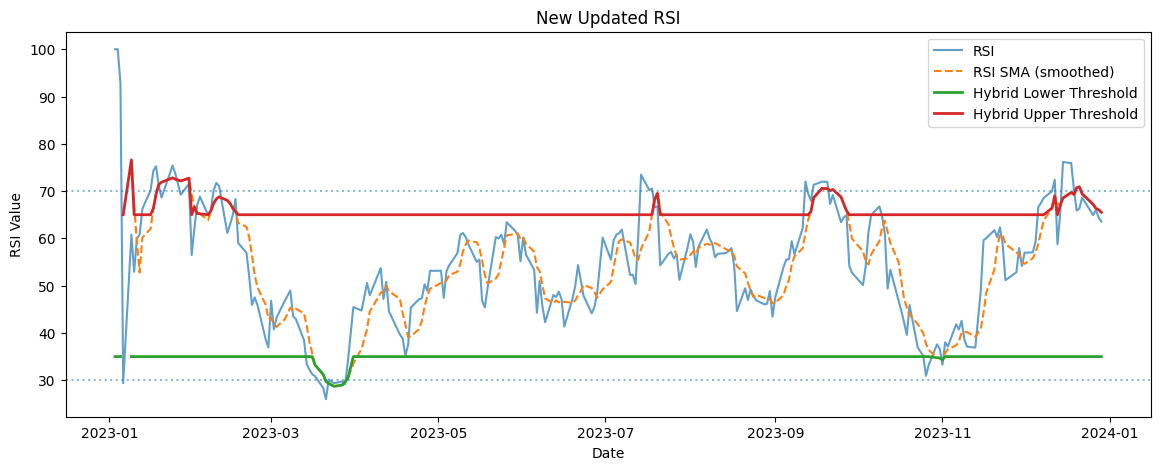

In [36]:
plt.figure(figsize=(14, 5))


plt.plot(df.index, df["RSI"], label="RSI", alpha=0.7)
plt.plot(df.index, df["RSI_SMA"], label="RSI SMA (smoothed)", linestyle="--")


plt.plot(df.index, df["RSI_Lower"], label="Hybrid Lower Threshold", linewidth=2)
plt.plot(df.index, df["RSI_Upper"], label="Hybrid Upper Threshold", linewidth=2)


plt.axhline(30, linestyle=":", alpha=0.5)
plt.axhline(70, linestyle=":", alpha=0.5)

plt.title("New Updated RSI")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.legend()
plt.show()


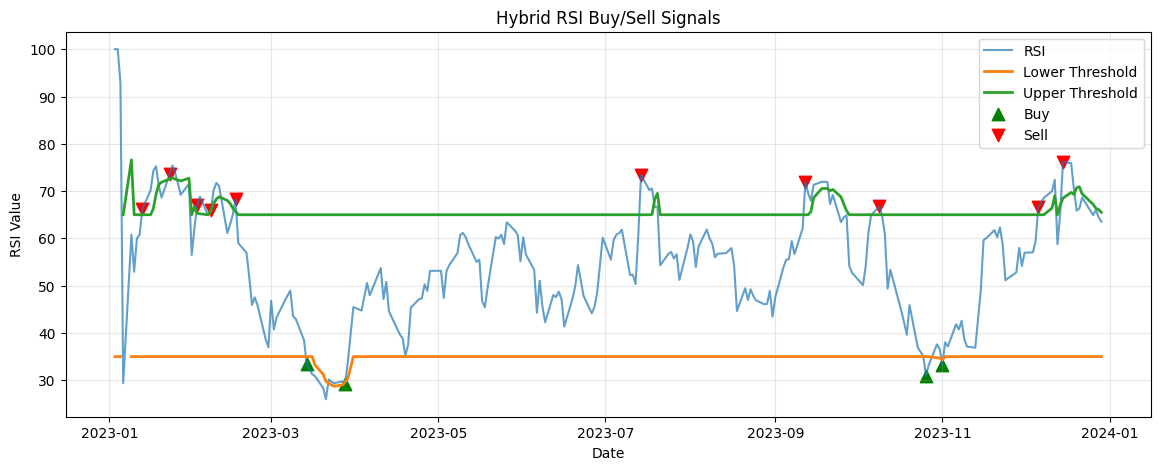

In [39]:
plt.figure(figsize=(14, 5))


plt.plot(df.index, df["RSI"], label="RSI", alpha=0.7)
plt.plot(df.index, df["RSI_Lower"], label="Lower Threshold", linewidth=2)
plt.plot(df.index, df["RSI_Upper"], label="Upper Threshold", linewidth=2)


plt.scatter(
    df.index[df["RSI_Buy"]],
    df.loc[df["RSI_Buy"], "RSI"],
    marker="^",
    color="green",
    s=80,
    label="Buy"
)

plt.scatter(
    df.index[df["RSI_Sell"]],
    df.loc[df["RSI_Sell"], "RSI"],
    marker="v",
    color="red",
    s=80,
    label="Sell"
)


plt.title("Hybrid RSI Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
